# Laboratorio 2 - Data Science

In [145]:
!pip install --upgrade pip
!pip install --upgrade numpy tensorflow
!pip install numpy==1.23.5

  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
  Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
graphdatascience 1.13 requires numpy<2.0, but you have numpy 2.1.3 which is incompatible.
graphdatascience 1.13 requires pyarrow<19.0,>=15.0.2, but you have pyarrow 21.0.0 which is incompatible.
graphdatascience 1.13 requires tenacity>=9.0, but you have tenacity 8.5.0 which is incompatible.
langchain 0.3.7 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
langchain 0.3.7 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 2.5.2 which is incompatible.
langchain-community 0.3.7 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
langchain-pinecone 0.2.0 requires numpy<2,>=1; python_version < "3.12", but you have numpy 2.1.3 which is incompatible.
streamlit 1.34.0 requires numpy<2,>=1.19.3, but you have numpy 2.1.3 which is inc

  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
graphdatascience 1.13 requires pyarrow<19.0,>=15.0.2, but you have pyarrow 21.0.0 which is incompatible.
graphdatascience 1.13 requires tenacity>=9.0, but you have tenacity 8.5.0 which is incompatible.
langchain 0.3.7 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 2.5.2 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
streamlit 1.34.0 requires pillow<11,>=7.1.0, but you have pillow 11.3.0 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.3 which is incompatible.


In [146]:
import numpy as np
import tensorflow as tf

(X_entreno, y_entreno), (X_prueba, y_prueba) = tf.keras.datasets.mnist.load_data()
X_entreno.shape

(60000, 28, 28)

In [147]:
assert X_entreno.shape == (60000, 28, 28)
assert X_prueba.shape == (10000, 28, 28)
assert y_entreno.shape == (60000,)
assert y_prueba.shape == (10000,)

In [148]:
num_obs_validacion = y_prueba.shape[0]
num_obs_prueba = y_prueba.shape[0]


In [149]:
X_entreno_normalizado = X_entreno / 255
X_prueba_normalizado = X_prueba / 255

In [150]:
X_validacion = X_entreno_normalizado[-num_obs_validacion: , : , : ]
y_validacion = y_entreno[-num_obs_validacion:]

In [151]:
X_entreno = X_entreno_normalizado[ : X_entreno_normalizado.shape[0] - num_obs_validacion, : , : ]
y_entreno = y_entreno[ : y_entreno.shape[0] - num_obs_validacion]
num_obs_entreno = y_entreno.shape[0]

In [152]:
BATCH_SIZE = 100
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

BIG_BATCH = 10000
datos_entreno_bigbatch = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(BIG_BATCH)
datos_validacion_bigbatch = datos_validacion.batch(BIG_BATCH)
datos_prueba_bigbatch = datos_prueba.batch(BIG_BATCH)

datos_entreno = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(BATCH_SIZE)
datos_validacion = datos_validacion.batch(BATCH_SIZE)
datos_prueba = datos_prueba.batch(BATCH_SIZE)

# Inicializar arrays para guardar resultados
training_times = []
test_accuracies = []
test_losses = []


## Modelo

In [153]:
# Vars constantes
from matplotlib import pyplot as plt
import time
NUM_EPOCHS = 20

class RNN():
    def __init__(
            self,
            entrada,
            salida,
            capa_escondida,
        ):
        self.entrada = entrada
        self.salida = salida
        self.capa_escondida = capa_escondida
        
        self.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            
            tf.keras.layers.Dense(capa_escondida, activation='relu'), # 2nda capa escondida

            tf.keras.layers.Dense(salida, activation='softmax') # capa salida
        ])
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, train_data, validation_data, num_epochs, verbose=0):
        start_time = time.time()
        self.history = self.model.fit(
            train_data,
            epochs = num_epochs, 
            validation_data = validation_data,
            verbose = verbose
        )
        end_time = time.time()
        train_loss = self.history.history['loss'][-1]
        train_acc = self.history.history['accuracy'][-1]
        val_loss = self.history.history['val_loss'][-1]
        val_acc = self.history.history['val_accuracy'][-1]
        t_time = end_time - start_time
        return (train_loss, train_acc, val_loss, val_acc, t_time)
    
    def test(self, test_data):
        loss, accuracy = self.model.evaluate(test_data)
        return (loss, accuracy)
    
    def plot_accuracy(self, title):
        plt.plot(self.history.history['accuracy'], label="Train")
        plt.plot(self.history.history['val_accuracy'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def plot_loss(self, title):
        plt.plot(self.history.history['loss'], label="Train")
        plt.plot(self.history.history['val_loss'], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

## 1. Modular Neuronas de capas internas

In [154]:
# iterar por cada una de las topologias
performance_1 = [] # almacenamiento de resultados

for inner_size in [50, 100, 200, 300, 500]:
    # Inicializar RNN
    m1 = RNN(784, 10, inner_size)
    # Compilar otpimizador
    m1.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Metricas de etrenamiento
    (e_loss, e_acc, _, _, t_time) = m1.train(datos_entreno, datos_validacion, num_epochs=20)
    # Metricas de prueba
    t_loss, t_acc = m1.test(datos_prueba)
    if(inner_size==200):
        training_times.append(t_time)  # Guardar tiempo
        test_losses.append(t_loss)     # Guardar pérdida
        test_accuracies.append(t_acc)  # Guardar accuracy
    performance_1.append({"Ancho": inner_size, "e_loss": e_loss, "e_acc": e_acc, "t_loss": t_loss, "t_acc": t_acc, "training_time": t_time})
    print(f"finished for inner size {inner_size}")
    

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 21.1605
finished for inner size 50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9736 - loss: 21.0034   
finished for inner size 100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9754 - loss: 24.3579
finished for inner size 200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9754 - loss: 24.3431
finished for inner size 300
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9741 - loss: 25.3854
finished for inner size 500


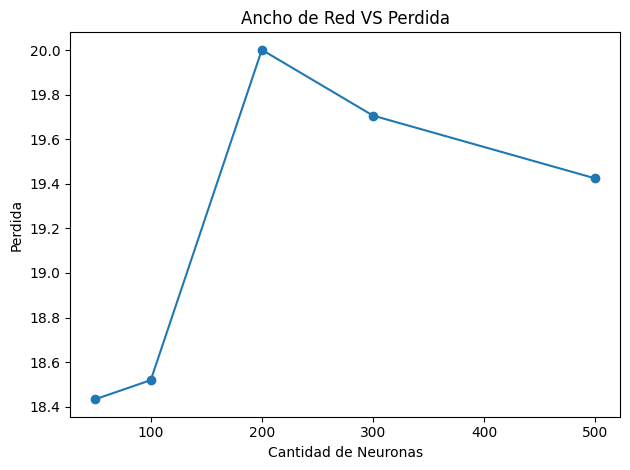

In [155]:
import pandas as pd
df1 = pd.DataFrame(performance_1)
plt.title("Ancho de Red VS Perdida")
plt.plot(df1["Ancho"], df1["t_loss"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Perdida")
plt.tight_layout()
plt.show()

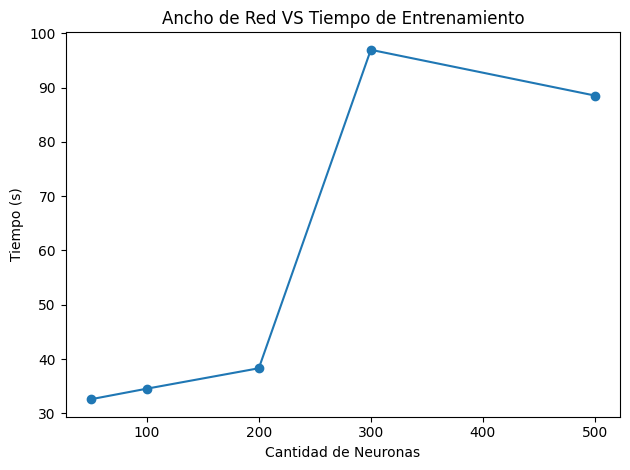

In [156]:
plt.title("Ancho de Red VS Tiempo de Entrenamiento")
plt.plot(df1["Ancho"], df1["training_time"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Tiempo (s)")
plt.tight_layout()
plt.show()

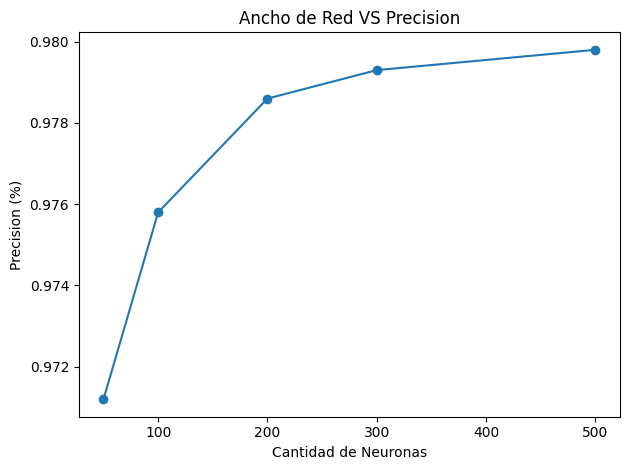

In [157]:
plt.title("Ancho de Red VS Precision")
plt.plot(df1["Ancho"], df1["t_acc"], '-o')
plt.xlabel("Cantidad de Neuronas")
plt.ylabel("Precision (%)")
plt.tight_layout()
plt.show()

In [158]:
df1

,Ancho,e_loss,e_acc,t_loss,t_acc,training_time
0,50,0.032775,0.99092,18.432726,0.9712,32.597463
1,100,0.007700,0.99882,18.518778,0.9758,34.546121
2,200,0.004296,0.99906,20.002850,0.9786,38.306117
3,300,0.005072,0.99862,19.707436,0.9793,96.944023
4,500,0.002698,0.99926,19.425262,0.9798,88.522415


## 2. Profundidad de Red

In [159]:
# Modelo con una capa interna
m2_one_layer = RNN(784, 10, 200)
m2_one_layer.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(200, activation='relu'), # 1a capa escondida
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m2_one_layer.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modelo con 2 capas internas
m2_two_layer = RNN(784, 10, 200)
m2_two_layer.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(200, activation='relu'), # 1a capa escondida
            tf.keras.layers.Dense(200, activation='relu'), # 2a capa escondida
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m2_two_layer.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\50250\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [160]:
for i, layer in enumerate(m2_one_layer.model.layers):
    weights = layer.get_weights() 
    print(f"Layer {i}: {layer.name}")
    for j, param in enumerate(weights):
        print(f"  Param {j} shape: {param.shape}")
m2_one_layer.model.summary()

Layer 0: flatten_127
Layer 1: dense_394
  Param 0 shape: (784, 200)
  Param 1 shape: (200,)
Layer 2: dense_395
  Param 0 shape: (200, 10)
  Param 1 shape: (10,)


Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_127 (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_395 (Dense)               │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,010 (621.13 KB)

 Trainable params: 159,010 (621.13 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
for i, layer in enumerate(m2_two_layer.model.layers):
    weights = layer.get_weights()
    print(f"Layer {i}: {layer.name}")
    for j, param in enumerate(weights):
        print(f"  Param {j} shape: {param.shape}")
m2_two_layer.model.summary()

Layer 0: flatten_129
Layer 1: dense_398
  Param 0 shape: (784, 200)
  Param 1 shape: (200,)
Layer 2: dense_399
  Param 0 shape: (200, 200)
  Param 1 shape: (200,)
Layer 3: dense_400
  Param 0 shape: (200, 10)
  Param 1 shape: (10,)


Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_129 (Flatten)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_400 (Dense)               │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,210 (778.16 KB)

 Trainable params: 199,210 (778.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
500/500 - 3s - 6ms/step - accuracy: 0.9093 - loss: 0.3258 - val_accuracy: 0.9496 - val_loss: 0.1763
Epoch 2/20
500/500 - 2s - 5ms/step - accuracy: 0.9571 - loss: 0.1461 - val_accuracy: 0.9628 - val_loss: 0.1285
Epoch 3/20
500/500 - 2s - 5ms/step - accuracy: 0.9699 - loss: 0.1029 - val_accuracy: 0.9685 - val_loss: 0.1071
Epoch 4/20
500/500 - 2s - 4ms/step - accuracy: 0.9783 - loss: 0.0761 - val_accuracy: 0.9728 - val_loss: 0.0948
Epoch 5/20
500/500 - 2s - 4ms/step - accuracy: 0.9830 - loss: 0.0584 - val_accuracy: 0.9748 - val_loss: 0.0855
Epoch 6/20
500/500 - 2s - 5ms/step - accuracy: 0.9864 - loss: 0.0472 - val_accuracy: 0.9737 - val_loss: 0.0808
Epoch 7/20
500/500 - 2s - 4ms/step - accuracy: 0.9894 - loss: 0.0375 - val_accuracy: 0.9763 - val_loss: 0.0768
Epoch 8/20
500/500 - 2s - 4ms/step - accuracy: 0.9918 - loss: 0.0300 - val_accuracy: 0.9773 - val_loss: 0.0795
Epoch 9/20
500/500 - 2s - 5ms/step - accuracy: 0.9932 - loss: 0.0252 - val_accuracy: 0.9765 - val_loss: 0.0790
E

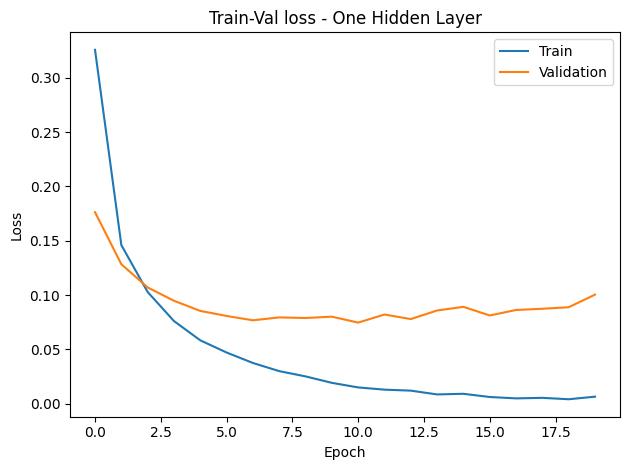

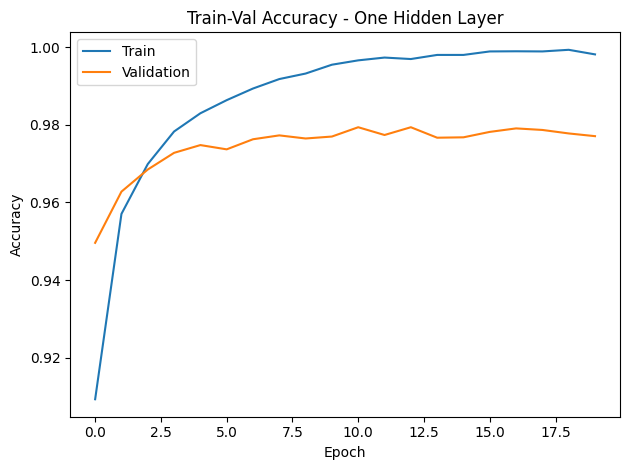

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9701 - loss: 25.5422   
Testing loss: 21.25138282775879, Testing Accuracy: 0.9749000072479248


In [162]:
# Entrenamiento 1a capa
(e_loss, e_acc, _, _, t_time) = m2_one_layer.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m2_one_layer.plot_loss("Train-Val loss - One Hidden Layer")
m2_one_layer.plot_accuracy("Train-Val Accuracy - One Hidden Layer")
t_loss, t_acc = m2_one_layer.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 3s - 7ms/step - accuracy: 0.9167 - loss: 0.2862 - val_accuracy: 0.9647 - val_loss: 0.1263
Epoch 2/20
500/500 - 2s - 3ms/step - accuracy: 0.9671 - loss: 0.1085 - val_accuracy: 0.9731 - val_loss: 0.0942
Epoch 3/20
500/500 - 2s - 3ms/step - accuracy: 0.9780 - loss: 0.0715 - val_accuracy: 0.9688 - val_loss: 0.1026
Epoch 4/20
500/500 - 2s - 3ms/step - accuracy: 0.9839 - loss: 0.0513 - val_accuracy: 0.9777 - val_loss: 0.0759
Epoch 5/20
500/500 - 2s - 3ms/step - accuracy: 0.9880 - loss: 0.0377 - val_accuracy: 0.9785 - val_loss: 0.0815
Epoch 6/20
500/500 - 2s - 3ms/step - accuracy: 0.9911 - loss: 0.0285 - val_accuracy: 0.9763 - val_loss: 0.0843
Epoch 7/20
500/500 - 2s - 3ms/step - accuracy: 0.9926 - loss: 0.0223 - val_accuracy: 0.9766 - val_loss: 0.0860
Epoch 8/20
500/500 - 2s - 3ms/step - accuracy: 0.9944 - loss: 0.0174 - val_accuracy: 0.9766 - val_loss: 0.0927
Epoch 9/20
500/500 - 2s - 3ms/step - accuracy: 0.9934 - loss: 0.0188 - val_accuracy: 0.9748 - val_loss: 0.1045
E

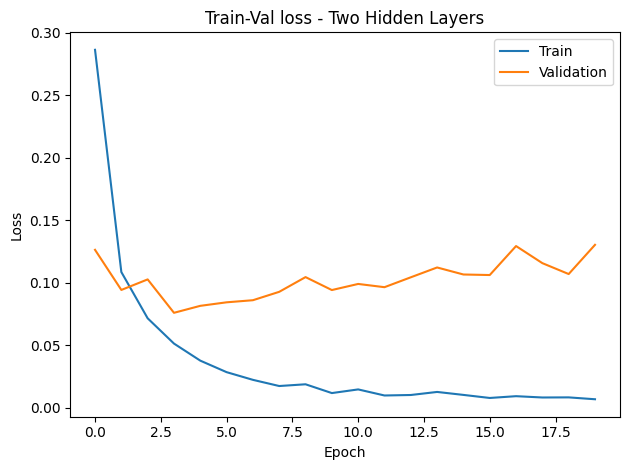

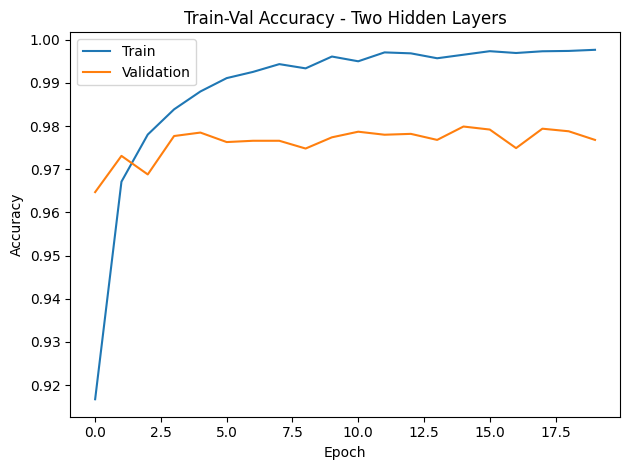

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9736 - loss: 33.2817
Testing loss: 26.6995849609375, Testing Accuracy: 0.9779999852180481


In [163]:
# Entrenamiento 2 capas
(e_loss, e_acc, _, _, t_time) = m2_two_layer.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m2_two_layer.plot_loss("Train-Val loss - Two Hidden Layers")
m2_two_layer.plot_accuracy("Train-Val Accuracy - Two Hidden Layers")
t_loss, t_acc = m2_two_layer.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

## 3. Redes profunas

Epoch 1/20
500/500 - 4s - 7ms/step - accuracy: 0.9148 - loss: 0.2889 - val_accuracy: 0.9579 - val_loss: 0.1363
Epoch 2/20
500/500 - 2s - 5ms/step - accuracy: 0.9704 - loss: 0.0980 - val_accuracy: 0.9730 - val_loss: 0.0865
Epoch 3/20
500/500 - 2s - 5ms/step - accuracy: 0.9798 - loss: 0.0663 - val_accuracy: 0.9690 - val_loss: 0.1049
Epoch 4/20
500/500 - 2s - 5ms/step - accuracy: 0.9834 - loss: 0.0513 - val_accuracy: 0.9739 - val_loss: 0.0940
Epoch 5/20
500/500 - 3s - 5ms/step - accuracy: 0.9888 - loss: 0.0359 - val_accuracy: 0.9773 - val_loss: 0.0816
Epoch 6/20
500/500 - 2s - 5ms/step - accuracy: 0.9896 - loss: 0.0329 - val_accuracy: 0.9728 - val_loss: 0.1106
Epoch 7/20
500/500 - 3s - 5ms/step - accuracy: 0.9905 - loss: 0.0306 - val_accuracy: 0.9772 - val_loss: 0.0862
Epoch 8/20
500/500 - 2s - 5ms/step - accuracy: 0.9922 - loss: 0.0239 - val_accuracy: 0.9741 - val_loss: 0.1096
Epoch 9/20
500/500 - 2s - 5ms/step - accuracy: 0.9946 - loss: 0.0188 - val_accuracy: 0.9751 - val_loss: 0.1026
E

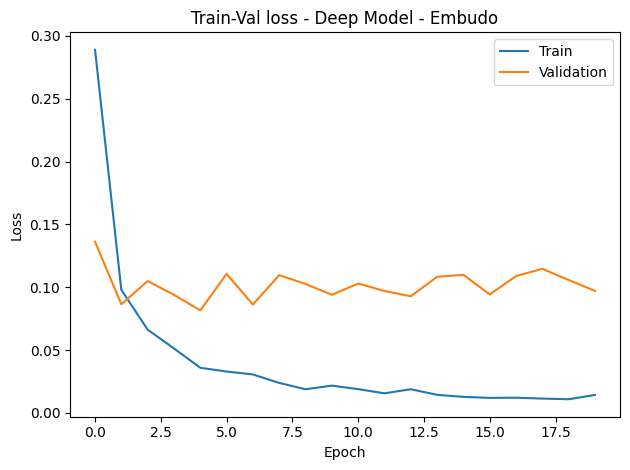

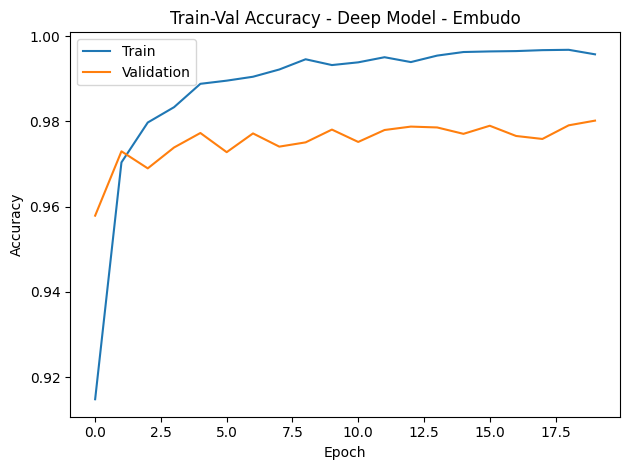

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 26.1737  
Testing loss: 21.892574310302734, Testing Accuracy: 0.9789000153541565


In [164]:
# Init
m3_a = RNN(784, 10, 200)
m3_a.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_a.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_a.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m3_a.plot_loss("Train-Val loss - Deep Model - Embudo")
m3_a.plot_accuracy("Train-Val Accuracy - Deep Model - Embudo")

# Test
t_loss, t_acc = m3_a.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy

print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 4s - 7ms/step - accuracy: 0.9185 - loss: 0.2714 - val_accuracy: 0.9588 - val_loss: 0.1369
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9666 - loss: 0.1106 - val_accuracy: 0.9693 - val_loss: 0.1052
Epoch 3/20
500/500 - 3s - 5ms/step - accuracy: 0.9762 - loss: 0.0783 - val_accuracy: 0.9714 - val_loss: 0.1027
Epoch 4/20
500/500 - 3s - 5ms/step - accuracy: 0.9826 - loss: 0.0574 - val_accuracy: 0.9744 - val_loss: 0.0886
Epoch 5/20
500/500 - 3s - 5ms/step - accuracy: 0.9843 - loss: 0.0492 - val_accuracy: 0.9729 - val_loss: 0.0985
Epoch 6/20
500/500 - 3s - 5ms/step - accuracy: 0.9878 - loss: 0.0377 - val_accuracy: 0.9759 - val_loss: 0.0950
Epoch 7/20
500/500 - 3s - 5ms/step - accuracy: 0.9890 - loss: 0.0360 - val_accuracy: 0.9771 - val_loss: 0.0856
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9897 - loss: 0.0319 - val_accuracy: 0.9786 - val_loss: 0.0934
Epoch 9/20
500/500 - 3s - 6ms/step - accuracy: 0.9912 - loss: 0.0278 - val_accuracy: 0.9745 - val_loss: 0.1156
E

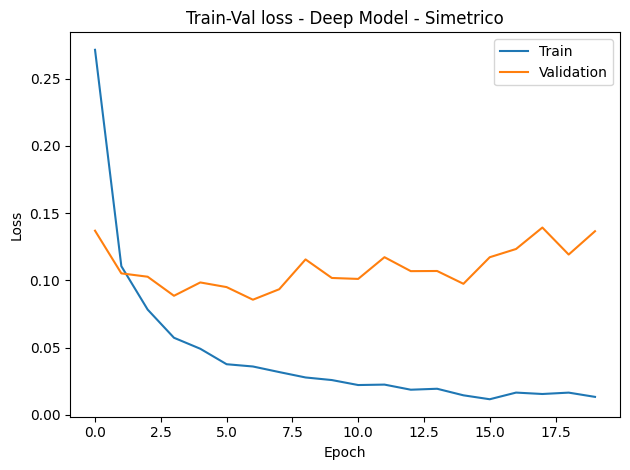

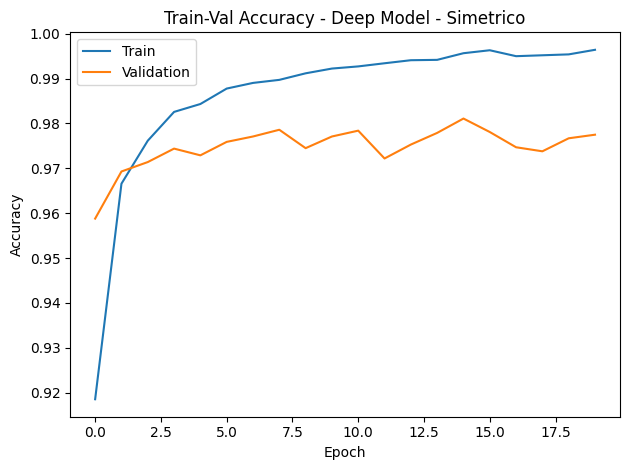

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9757 - loss: 29.1191
Testing loss: 22.75800132751465, Testing Accuracy: 0.9803000092506409


In [165]:
# Init
m3_b = RNN(784, 10, 200)
m3_b.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_b.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_b.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
m3_b.plot_loss("Train-Val loss - Deep Model - Simetrico")
m3_b.plot_accuracy("Train-Val Accuracy - Deep Model - Simetrico")
training_times.append(t_time)  # Guardar tiempo
# Test
t_loss, t_acc = m3_b.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

Epoch 1/20
500/500 - 3s - 6ms/step - accuracy: 0.9137 - loss: 0.2870 - val_accuracy: 0.9607 - val_loss: 0.1317
Epoch 2/20
500/500 - 2s - 5ms/step - accuracy: 0.9666 - loss: 0.1078 - val_accuracy: 0.9623 - val_loss: 0.1288
Epoch 3/20
500/500 - 2s - 5ms/step - accuracy: 0.9776 - loss: 0.0740 - val_accuracy: 0.9740 - val_loss: 0.0935
Epoch 4/20
500/500 - 2s - 5ms/step - accuracy: 0.9824 - loss: 0.0552 - val_accuracy: 0.9734 - val_loss: 0.0927
Epoch 5/20
500/500 - 2s - 5ms/step - accuracy: 0.9849 - loss: 0.0464 - val_accuracy: 0.9716 - val_loss: 0.1074
Epoch 6/20
500/500 - 2s - 5ms/step - accuracy: 0.9875 - loss: 0.0394 - val_accuracy: 0.9752 - val_loss: 0.0892
Epoch 7/20
500/500 - 2s - 5ms/step - accuracy: 0.9892 - loss: 0.0343 - val_accuracy: 0.9785 - val_loss: 0.0836
Epoch 8/20
500/500 - 2s - 5ms/step - accuracy: 0.9909 - loss: 0.0297 - val_accuracy: 0.9759 - val_loss: 0.0951
Epoch 9/20
500/500 - 2s - 5ms/step - accuracy: 0.9919 - loss: 0.0270 - val_accuracy: 0.9786 - val_loss: 0.0982
E

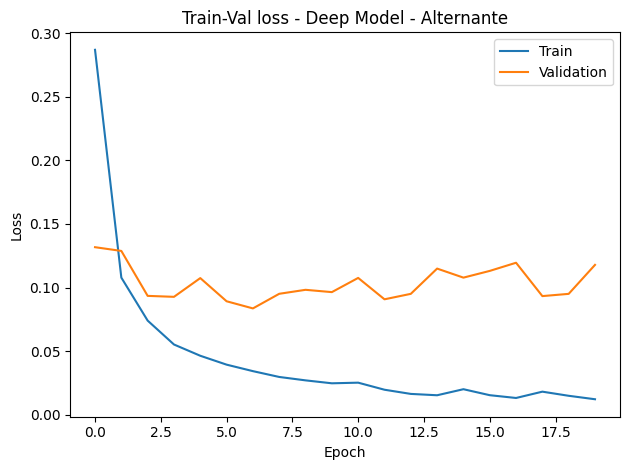

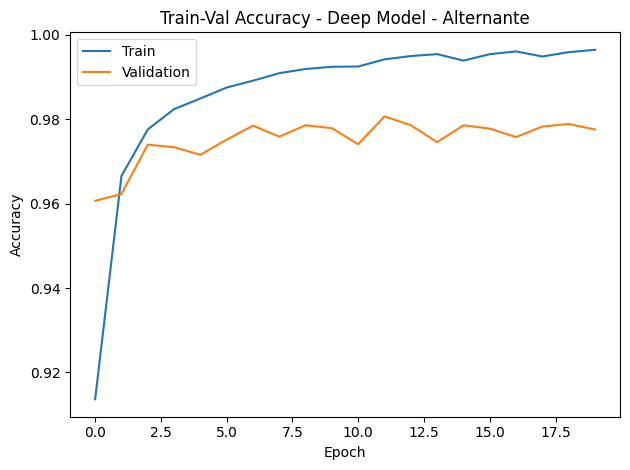

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9695 - loss: 30.0821
Testing loss: 25.381786346435547, Testing Accuracy: 0.9740999937057495


In [166]:
# kida random
# Init
m3_c = RNN(784, 10, 200)
m3_c.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m3_c.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m3_c.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m3_c.plot_loss("Train-Val loss - Deep Model - Alternante")
m3_c.plot_accuracy("Train-Val Accuracy - Deep Model - Alternante")

# Test
t_loss, t_acc = m3_c.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 4. Funciones de Activacion 1

Epoch 1/20
500/500 - 4s - 9ms/step - accuracy: 0.6895 - loss: 0.9187 - val_accuracy: 0.9013 - val_loss: 0.3488
Epoch 2/20
500/500 - 3s - 7ms/step - accuracy: 0.9137 - loss: 0.3033 - val_accuracy: 0.9373 - val_loss: 0.2215
Epoch 3/20
500/500 - 3s - 6ms/step - accuracy: 0.9414 - loss: 0.2042 - val_accuracy: 0.9552 - val_loss: 0.1583
Epoch 4/20
500/500 - 3s - 6ms/step - accuracy: 0.9552 - loss: 0.1548 - val_accuracy: 0.9602 - val_loss: 0.1414
Epoch 5/20
500/500 - 3s - 6ms/step - accuracy: 0.9638 - loss: 0.1242 - val_accuracy: 0.9647 - val_loss: 0.1235
Epoch 6/20
500/500 - 3s - 6ms/step - accuracy: 0.9703 - loss: 0.1020 - val_accuracy: 0.9680 - val_loss: 0.1108
Epoch 7/20
500/500 - 3s - 6ms/step - accuracy: 0.9738 - loss: 0.0886 - val_accuracy: 0.9690 - val_loss: 0.1054
Epoch 8/20
500/500 - 3s - 6ms/step - accuracy: 0.9778 - loss: 0.0757 - val_accuracy: 0.9699 - val_loss: 0.1012
Epoch 9/20
500/500 - 3s - 5ms/step - accuracy: 0.9805 - loss: 0.0644 - val_accuracy: 0.9721 - val_loss: 0.1038
E

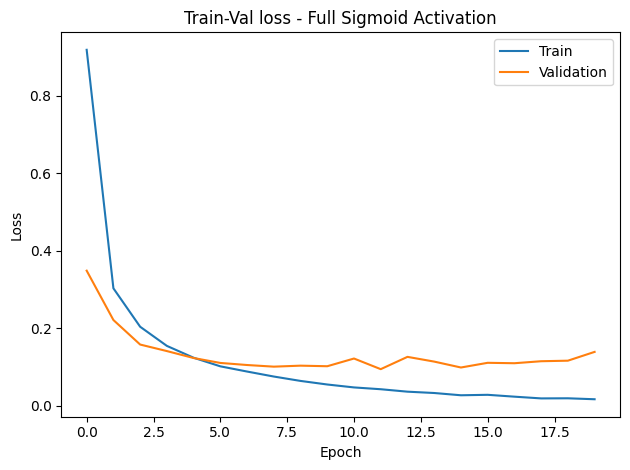

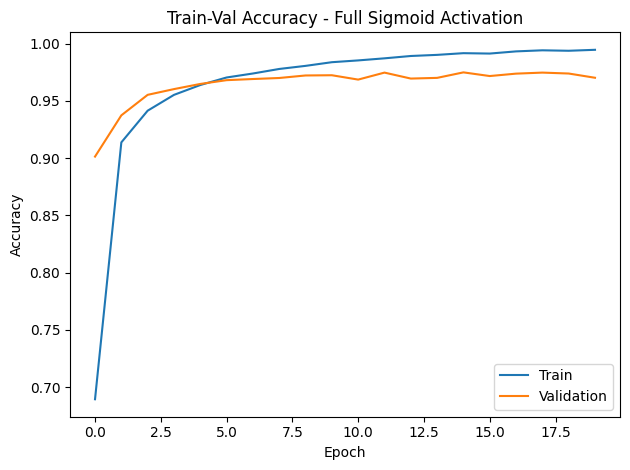

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9514 - loss: 0.2481
Testing loss: 0.20852415263652802, Testing Accuracy: 0.958299994468689


In [167]:
# Init
m4 = RNN(784, 10, 200)
m4.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(256, activation='sigmoid'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m4.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m4.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m4.plot_loss("Train-Val loss - Full Sigmoid Activation")
m4.plot_accuracy("Train-Val Accuracy - Full Sigmoid Activation")

# Test
t_loss, t_acc = m4.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 5. Funciones de Activacion 2

Epoch 1/20
500/500 - 4s - 8ms/step - accuracy: 0.9199 - loss: 0.2631 - val_accuracy: 0.9521 - val_loss: 0.1596
Epoch 2/20
500/500 - 3s - 5ms/step - accuracy: 0.9683 - loss: 0.1045 - val_accuracy: 0.9689 - val_loss: 0.1033
Epoch 3/20
500/500 - 3s - 6ms/step - accuracy: 0.9769 - loss: 0.0766 - val_accuracy: 0.9731 - val_loss: 0.0927
Epoch 4/20
500/500 - 3s - 5ms/step - accuracy: 0.9822 - loss: 0.0579 - val_accuracy: 0.9734 - val_loss: 0.0980
Epoch 5/20
500/500 - 3s - 5ms/step - accuracy: 0.9831 - loss: 0.0534 - val_accuracy: 0.9772 - val_loss: 0.0817
Epoch 6/20
500/500 - 3s - 5ms/step - accuracy: 0.9876 - loss: 0.0409 - val_accuracy: 0.9725 - val_loss: 0.1036
Epoch 7/20
500/500 - 3s - 6ms/step - accuracy: 0.9879 - loss: 0.0373 - val_accuracy: 0.9751 - val_loss: 0.1021
Epoch 8/20
500/500 - 3s - 5ms/step - accuracy: 0.9896 - loss: 0.0332 - val_accuracy: 0.9717 - val_loss: 0.1150
Epoch 9/20
500/500 - 3s - 5ms/step - accuracy: 0.9916 - loss: 0.0266 - val_accuracy: 0.9740 - val_loss: 0.1066
E

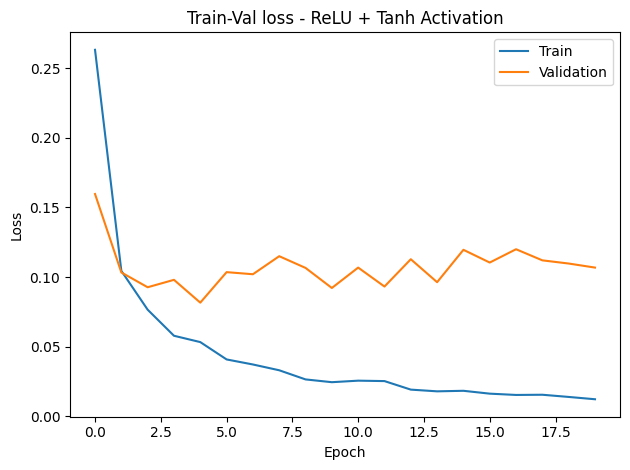

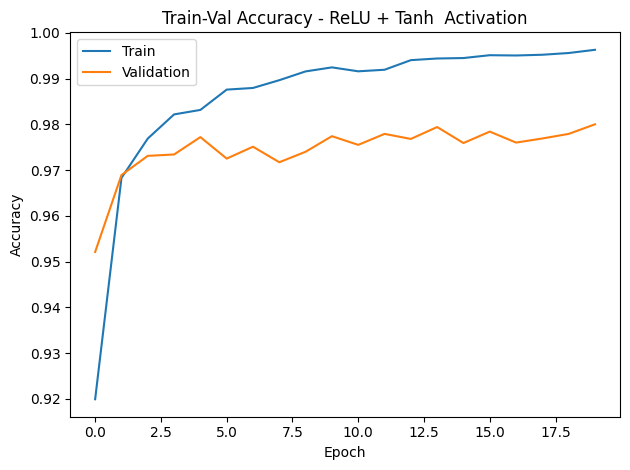

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9753 - loss: 0.1633
Testing loss: 0.13956744968891144, Testing Accuracy: 0.9783999919891357


In [168]:
# Init
m5 = RNN(784, 10, 200)
m5.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
m5.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
(e_loss, e_acc, _, _, t_time) = m5.train(datos_entreno, datos_validacion, num_epochs=20, verbose=2)
print(f"Training Time: {t_time}")
training_times.append(t_time)  # Guardar tiempo
m5.plot_loss("Train-Val loss - ReLU + Tanh Activation")
m5.plot_accuracy("Train-Val Accuracy - ReLU + Tanh  Activation")

# Test
t_loss, t_acc = m5.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

### 6. Tamaño Batch Grande

In [169]:
# iterar por cada una de las topologias
performance_2 = [] # almacenamiento de resultados

for batch_size in [100, 500, 1000, 5000, 10000]:
    # Realizar otra vez el shuffle
    datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
    datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
    datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

    datos_entreno_bigbatch = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(batch_size)
    datos_validacion_bigbatch = datos_validacion.batch(batch_size)
    datos_prueba_bigbatch = datos_prueba.batch(batch_size)

    # Inicializar RNN
    m6 = RNN(784, 10, 256)
    m6.model = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='tanh'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax') # capa salida
        ])
    # Compilar otpimizador
    m6.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Metricas de etrenamiento
    (e_loss, e_acc, _, _, t_time) = m6.train(datos_entreno_bigbatch, datos_validacion_bigbatch, num_epochs=20)
    # Metricas de prueba
    t_loss, t_acc = m6.test(datos_prueba_bigbatch)
    performance_2.append({"batch_size": batch_size, "e_loss": e_loss, "e_acc": e_acc, "t_loss": t_loss, "t_acc": t_acc, "training_time": t_time})
    print(f"finished for bartch size {batch_size}")
    if(batch_size==10000):
        training_times.append(t_time)  # Guardar tiempo
        test_losses.append(t_loss)     # Guardar pérdida
        test_accuracies.append(t_acc)  # Guardar accuracy


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9757 - loss: 0.1426
finished for bartch size 100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9669 - loss: 0.2609
finished for bartch size 500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9634 - loss: 0.3124
finished for bartch size 1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9551 - loss: 0.2359 
finished for bartch size 5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9481 - loss: 0.2003
finished for bartch size 10000


In [170]:
df6 = pd.DataFrame(performance_2)
df6

,batch_size,e_loss,e_acc,t_loss,t_acc,training_time
0,100,0.013530,0.99614,0.132379,0.9786,55.686852
1,500,0.011697,0.99596,0.220509,0.9725,30.373454
2,1000,0.010833,0.99628,0.278612,0.9671,21.053735
3,5000,0.024134,0.99404,0.212426,0.9592,15.416216
4,10000,0.073147,0.97852,0.200265,0.9481,15.354201


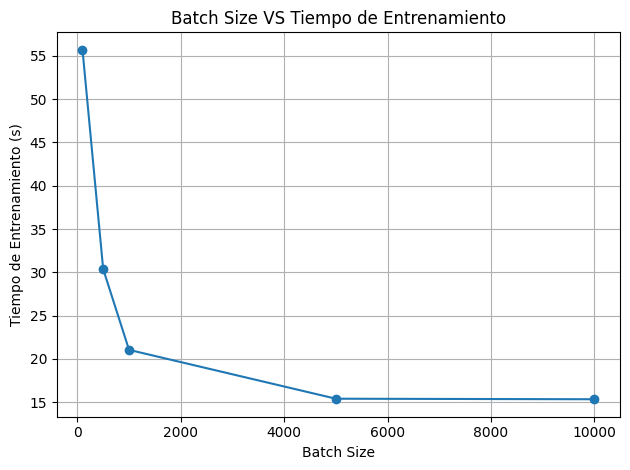

In [171]:
plt.plot(df6["batch_size"], df6["training_time"],'-o')
plt.xlabel("Batch Size")
plt.ylabel("Tiempo de Entrenamiento (s)")
plt.title("Batch Size VS Tiempo de Entrenamiento")
plt.grid()
plt.tight_layout()
plt.show()

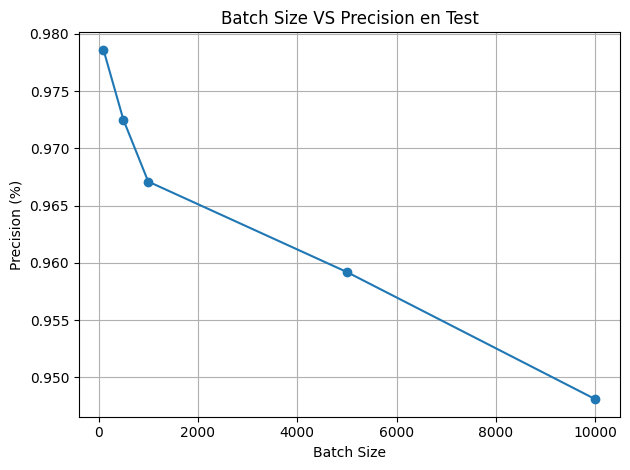

In [172]:
plt.plot(df6["batch_size"], df6["t_acc"],'-o')
plt.xlabel("Batch Size")
plt.ylabel("Precision (%)")
plt.title("Batch Size VS Precision en Test")
plt.grid()
plt.tight_layout()
plt.show()


## 7. Descenso de Gradiente Estocástico (SGD)

Para esta actividad se ajusta el tamaño de batch a 1, lo que implica entrenamiento con descenso de gradiente estocástico puro. Esto permite observar cómo cambia la estabilidad y el tiempo de ejecución del modelo.

**Objetivo**:
- Comparar tiempo de ejecución y precisión con configuraciones anteriores.
- Evaluar estabilidad del entrenamiento.
- Analizar si los resultados son coherentes con la teoría.


In [173]:
# Realizar otra vez el shuffle
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

datos_entreno_smallbatch = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(batch_size)
datos_validacion_smallbatch = datos_validacion.batch(1)
datos_prueba_smallbatch = datos_prueba.batch(1)

# Inicializar RNN
m7 = RNN(784, 10, 200)
# Metricas de etrenamiento
(e_loss, e_acc, _, _, t_time) = m7.train(datos_entreno_smallbatch, datos_validacion_smallbatch, num_epochs=20)
training_times.append(t_time)  # Guardar tiempo
# Metricas de prueba
t_loss, t_acc = m7.test(datos_prueba_smallbatch)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracy
# Imprimir resultados
print(f"Training Time: {t_time}")
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")

C:\Users\50250\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 10s 997us/step - accuracy: 0.9257 - loss: 32.6132
Training Time: 206.29009985923767
Testing loss: 29.189922332763672, Testing Accuracy: 0.934499979019165


In [174]:
print(training_times)
print(test_losses)
print(test_accuracies)

[38.306116819381714, 43.38285279273987, 33.76331663131714, 51.13825964927673, 54.693408727645874, 47.81944465637207, 59.24158501625061, 55.961930990219116, 15.354201316833496, 206.29009985923767]
[20.002849578857422, 21.25138282775879, 26.6995849609375, 21.892574310302734, 22.75800132751465, 25.381786346435547, 0.20852415263652802, 0.13956744968891144, 0.20026510953903198, 29.189922332763672]
[0.978600025177002, 0.9749000072479248, 0.9779999852180481, 0.9789000153541565, 0.9803000092506409, 0.9740999937057495, 0.958299994468689, 0.9783999919891357, 0.9480999708175659, 0.934499979019165]


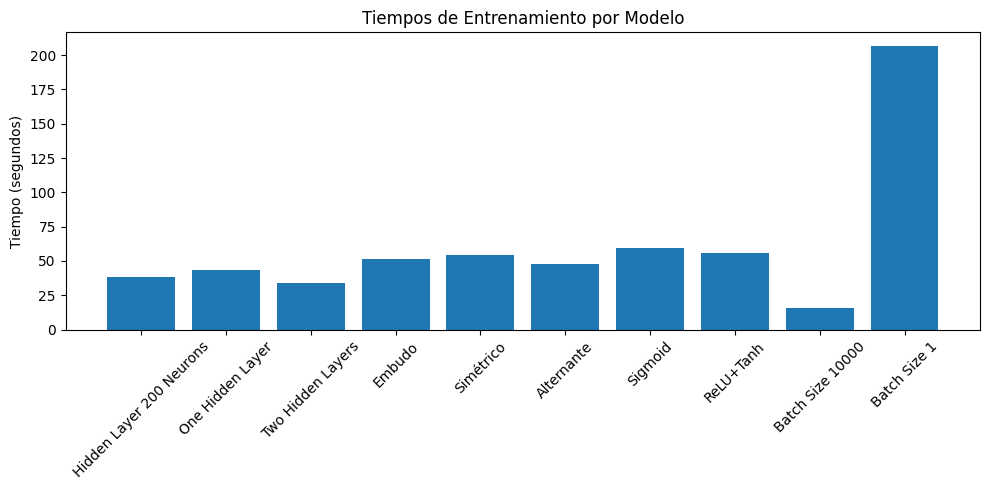

In [176]:
model_names = [
    "Hidden Layer 200 Neurons","One Hidden Layer", "Two Hidden Layers", "Embudo", "Simétrico",
    "Alternante", "Sigmoid", "ReLU+Tanh", "Batch Size 10000", "Batch Size 1"
]

# Crear DataFrame para la tabla comparativa
df_summary = pd.DataFrame({
    "Modelo": model_names,
    "Tiempo de Entrenamiento (s)": training_times,
    "Pérdida en Prueba": test_losses,
    "Precisión en Prueba": test_accuracies
})

# Graficar tiempos de entrenamiento
plt.figure(figsize=(10, 5))
plt.bar(model_names, training_times)
plt.title("Tiempos de Entrenamiento por Modelo")
plt.ylabel("Tiempo (segundos)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## 8. Tasa de aprendizaje baja


Training Time (Low LR): 37.45862150192261


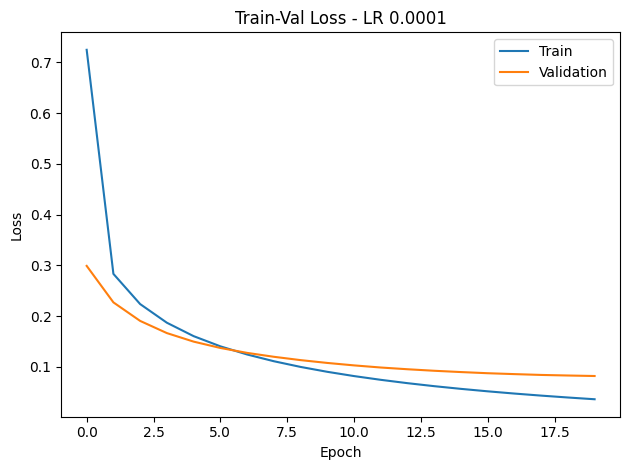

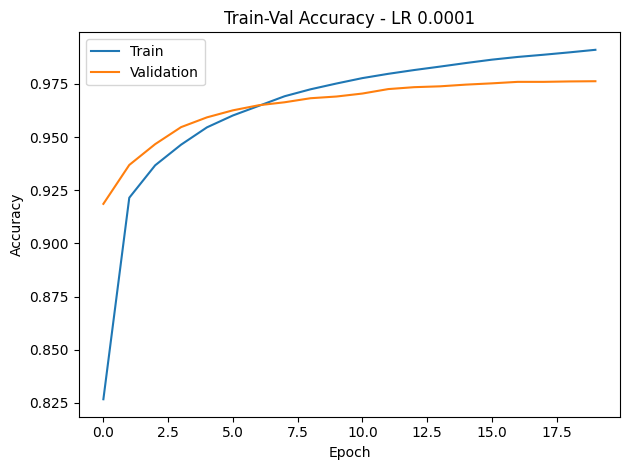

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9730 - loss: 14.3166
Testing loss: 12.794492721557617, Testing Accuracy: 0.9764000177383423


In [185]:

BATCH_SIZE = 100
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno)).batch(BATCH_SIZE)
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion)).batch(BATCH_SIZE)
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba)).batch(BATCH_SIZE)

# Crear y compilar modelo con tasa de aprendizaje baja
m8 = RNN(784, 10, 200)
m8.model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
m8.model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento
(e_loss, e_acc, _, _, t_time) = m8.train(datos_entreno, datos_validacion, num_epochs=20)
training_times.append(t_time)  # Guardar tiempo
print(f"Training Time (Low LR): {t_time}")
m8.plot_loss("Train-Val Loss - LR 0.0001")
m8.plot_accuracy("Train-Val Accuracy - LR 0.0001")

# Prueba
t_loss, t_acc = m8.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracya
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")



## 9.Tasa de Aprendizaje Alta 

Training Time (High LR): 36.89509057998657


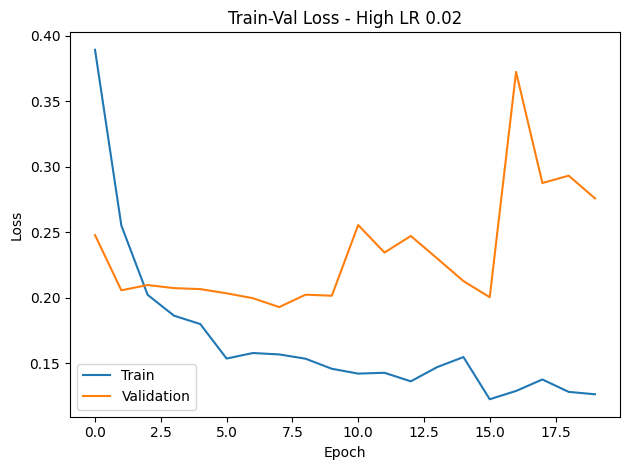

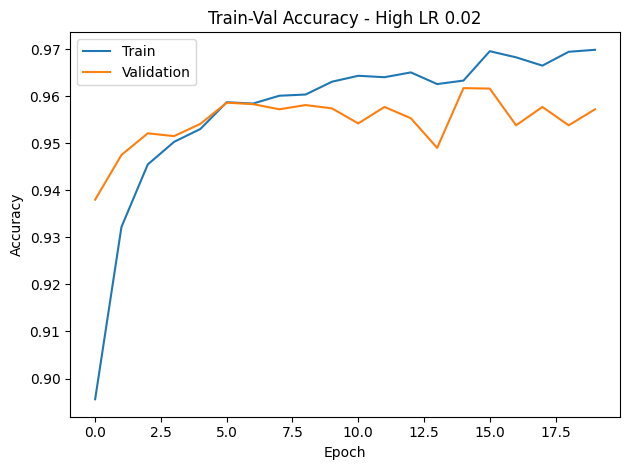

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 78.6825
Testing loss: 65.89105987548828, Testing Accuracy: 0.9527000188827515


In [187]:
# Crear y compilar modelo con tasa de aprendizaje alta
m9 = RNN(784, 10, 200)
m9.model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
m9.model.compile(
    optimizer=Adam(learning_rate=0.02),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento
(e_loss, e_acc, _, _, t_time) = m9.train(datos_entreno, datos_validacion, num_epochs=20)
training_times.append(t_time)  # Guardar tiempo
print(f"Training Time (High LR): {t_time}")
m9.plot_loss("Train-Val Loss - High LR 0.02")
m9.plot_accuracy("Train-Val Accuracy - High LR 0.02")

# Prueba
t_loss, t_acc = m9.test(datos_prueba)
test_losses.append(t_loss)     # Guardar pérdida
test_accuracies.append(t_acc)  # Guardar accuracya
print(f"Testing loss: {t_loss}, Testing Accuracy: {t_acc}")